# Objective

To reduce the number of dimensions of the Amazon food reviews dataset using t-SNE so that we can visualize it using a scatterplot. The plot should ideally segeregate positive and negative reviews so that we can visually distinguish them.

I'm not building a classification model here. The objective of this exercise is to drastically reduce the number of dimensions in text data and verify whether t-SNE is able to preserve the essence of the data.

As always, let's start by importing the libraries we need.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from nltk.stem.porter import PorterStemmer

The data is present on the disk in the form of a sqlite file. Let's connect to it to retrive the data we need.

In [2]:
# load sqlite database
con = sqlite3.connect(r'C:\Users\ucanr\aaic\database.sqlite')

Since the aim here is to just visualize the positive and negative reviews, I select only the reviews that aren't neutral. It's a fair assumption that the reviews with score = 3 are neutral.

In [3]:
df = pd.read_sql_query("select * from reviews where score <> 3;", con)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB


For this exercise, we want score to be a categorical feature.
* Mark reviews with rating > 3 as positive
* Mark reviews with rating < 3 as negative

In [5]:
m1 =  df['Score'] > 3 
m2 =  df['Score'] < 3 

df['Score'] = np.select([m1,m2], ['positive','negative'])

In [6]:
df.Score.value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

Let's change the datatype of Score in our Pandas dataframe to 'Category'. Using Categories instead of the default 'Object' datatype leads to performance improvement.

In [7]:
df['Score']=df['Score'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null category
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 36.6+ MB


In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Are there any duplicate rows in the dataset?
Just looking at the text column, we clearly see that there are duplicates.

In [9]:
df.duplicated('Text').value_counts()

False    363836
True     161978
dtype: int64

There are also a few anomalies in the data where the HelpfulnessNumerator is greater than the helpfulnessDenominator. We need to get rid of them.

In [10]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Let's drop these erraneous points using the drop() method given by pandas.

In [11]:
df.drop(df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']].index.tolist(), axis=0, inplace=True)

Verify whether the rows have been dropped.

In [12]:
df [df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525812 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525812 non-null int64
ProductId                 525812 non-null object
UserId                    525812 non-null object
ProfileName               525812 non-null object
HelpfulnessNumerator      525812 non-null int64
HelpfulnessDenominator    525812 non-null int64
Score                     525812 non-null category
Time                      525812 non-null int64
Summary                   525812 non-null object
Text                      525812 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 40.6+ MB


Now, let's drop the reviews which have the same data for the attributes:
* UserId
* ProfileName
* Time
* Text

These are the reviews for same products, duplicated in the dataset due to Amazon considering slight variations of the same product to be different products. i.e. A food item with red color would be different than the same item of green color. We need to drop these.

In [14]:
df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep = 'first', inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 0 to 525813
Data columns (total 10 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null category
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 28.1+ MB


Sort data by Time

In [16]:
df.sort_values('Time', ascending=True,inplace=True)

In [19]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


Dropping the duplicate significantly reduces the size of our dataframe.

In [20]:
df.shape

(364171, 10)

### Text Cleaning

Data collected from the web often contains unrendered HTML tags in them. Let's see if our reviews have them. We are only interested in the 'Text' column, because this is the column that will help us decide if a review is positive or negative. 

In [35]:
import re

i=0
for review in df['Text'].values:
    if (len(re.findall('<.*>', review))):
            i+=1
            r=review

In [36]:
print('Number of reviews which contain HTML tags: {}'.format(i), end='\n\n------------------\n\n')
print('Sample review containing HTML tags: {}'.format(r))

Number of reviews which contain HTML tags: 93153

------------------

Sample review containing HTML tags: They slush. All others turn into a frozen stick. A tasty piece of ice. Well, I don't like crunching ice, but I do like these because they freeze in a way that makes them not rock hard.<br /><br />Probably a chemical that prevents the ice-cube effect, that is no good for me, but I don't care, they are just too tasty and they can be eaten without using your teeth.<br /><br />So good.


Let's import some text processing libraries we need. 

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

Define the stemmer and a couple of functions we'll need

In [50]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemma = WordNetLemmatizer()

def clean_html(sentence, compiled_regex):
    cleaned_sentence = re.sub(compiled_regex, ' ', sentence)
    return cleaned_sentence

def clean_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned_sentence = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned_sentence)
    return cleaned_sentence

In [54]:
print(stop_words, end='\n\n-------------------------\n\n')
print('Stemmed form of "Goodness" is: {}'.format(porter.stem('Goodness')))
print('Lemmatized form of "Goodness" is: {}'.format(lemma.lemmatize('Goodness')))

{"haven't", 'hadn', 'ours', 'that', 'between', 'during', 'being', 'of', 'few', 'there', 't', 'below', "didn't", 'couldn', 'off', 'will', "doesn't", 'does', 've', 'have', 'their', 'hasn', 'the', "won't", 'here', 'my', 'am', 'should', "hadn't", 'whom', 'in', 'all', 'a', 'himself', 'as', 'm', 'are', "couldn't", 'both', "you're", 'into', 'such', 'y', "you've", "don't", 'wouldn', 're', 'from', 'itself', 'wasn', 'won', 'didn', 'over', 'ma', 'haven', 'than', 'me', 'herself', 'mightn', 'who', "that'll", 'them', 'did', 'but', 'above', 'll', 'needn', "you'd", 'yours', "she's", 'they', 'you', 'to', 'by', 'your', 'how', 'not', 'shouldn', 'after', 'weren', 'now', 'nor', 'isn', 'or', 'was', 'his', 'having', 'at', "hasn't", "it's", 'this', 'hers', "you'll", 'don', "isn't", 'so', 'be', 'mustn', "shan't", "wasn't", 'before', 'very', 'is', "should've", 'only', 'her', 'about', "shouldn't", 'o', 'any', 'it', 'd', "aren't", "needn't", 'theirs', 'own', 'for', 'other', 'aren', 'yourselves', 'some', 'i', 'whi

Code to clean the entire reviews column based on the checks mentioned above.

In [56]:
# #Code for implementing step-by-step the checks mentioned in the pre-processing phase
# # this code takes a while to run as it needs to run on 500k sentences.
# i=0
# str1=' '
# final_string=[]

# all_positive_words=[] # store words from +ve reviews here
# all_negative_words=[] # store words from -ve reviews here.

# s=''

# regex_html=re.compile('<.*?>')

# for review in df['Text'].values:
#     filtered_sentence=[]
#     #print(sent);
#     sent=clean_html(review, regex_html) # remove HTMl tags
#     for w in review.split():
#         for cleaned_words in clean_punctuation(w).split():
#             if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
#                 if(cleaned_words.lower() not in stop_words):
#                     s = (porter.stem(cleaned_words.lower())).encode('utf8')
#                     filtered_sentence.append(s)
#                     if (df['Score'].values)[i] == 'positive': 
#                         all_positive_words.append(s) #list of all words used to describe positive reviews
#                     if(df['Score'].values)[i] == 'negative':
#                         all_negative_words.append(s) #list of all words used to describe negative reviews reviews
#                 else:
#                     continue
#             else:
#                 continue 
#     #print(filtered_sentence)
#     str1 = b" ".join(filtered_sentence) #final string of cleaned words
#     #print("***********************************************************************")
    
#     final_string.append(str1)
#     i+=1

# df['cleaned_text']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [57]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


Considering how long it takes for a modest computer to run the above code for cleaning data, it's a good idea to store it  on disk for future use. The entire dataframe along with the newly created column "cleaned_data" is stored.

In [59]:
# conn = sqlite3.connect(r'C:\Users\ucanr\aaic\reviews_with_processed_text.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# df.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [3]:
# loading the dataframe again, since I lost all the data after OS restarted. Storing it on the disk was a wise decision.
con = sqlite3.connect(r'C:\Users\ucanr\aaic\reviews_with_processed_text.sqlite')
df = pd.read_sql_query('select * from Reviews', con)

### Bag of words

Let's vectorize the data using the simplest method first: BoW

There is class imbalance in our original dataset. The positive reviews are far more than the negative ones. Let's take 1500 positive and 1500 negative samples.

In [9]:
n = df['Score'] == 'negative'
p = df['Score'] == 'positive'
#df_n = df[df['Score']]
df_n = df[n][['cleaned_text','Score']][:1500]
df_p = df[p][['cleaned_text', 'Score']][:1500]

df_np = pd.concat([df_n, df_p])

#df_np = df_n.stack(df_p)
#len(df['Text'])
#df['cleaned_text'][0:10000]

In [12]:
count_vec = CountVectorizer()
final_counts = count_vec.fit_transform(df_np['cleaned_text'].values)

In [13]:
final_counts.get_shape()

(3000, 9415)

In [14]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [15]:
review_vector_3k = final_counts.toarray()

In [128]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(review_vector_3k)

C:\Users\ucanr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=33)

review_vector_3k_tsne = tsne.fit_transform(review_vector_3k)

In [17]:
review_vector_3k_tsne

array([[-14.415383 ,  -7.2258954],
       [ -6.333298 ,   3.4203813],
       [-13.030654 ,   5.443019 ],
       ...,
       [-15.207543 ,  -7.5832987],
       [  4.9479947,  -5.172777 ],
       [ 15.671542 ,   2.958944 ]], dtype=float32)

Above model took an hour to train. It's a good idea to store it on disk for later use.

In [18]:
import pickle
pickle_file = open('pickled_3k_reviews_tsne_bow.pkl', 'wb')
pickle.dump(review_vector_3k_tsne, pickle_file)
pickle_file.close()

In [19]:
review_vector_3k_tsne.shape

(3000, 2)

In [20]:
bow_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_bow_tsne_3k = pd.DataFrame(bow_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [21]:
df_bow_tsne_3k.head()


,First Dimension,Second Dimension,Label
0,-14.4154,-7.2259,negative
1,-6.3333,3.42038,negative
2,-13.0307,5.44302,negative
3,-13.5395,5.7427,negative
4,-4.17071,1.81495,negative


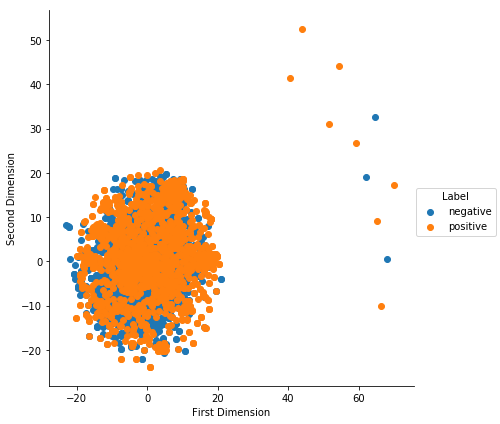

In [22]:
sbn.FacetGrid(df_bow_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

### Bigrams

In [34]:
all_positive_words = []

for w in df_p['cleaned_text']:
    all_positive_words.extend(w.split())
#all_positive_words

all_negative_words = []

for w in df_n['cleaned_text']:
    all_negative_words.extend(w.split())
#all_negative_words


In [39]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
print('Most common positive words: {}'.format(freq_dist_positive.most_common(10)))

freq_dist_negative = nltk.FreqDist(all_negative_words)
print('Most common negative words: {}'.format(freq_dist_negative.most_common(10)))

Most common positive words: [(b'like', 727), (b'tea', 697), (b'tast', 677), (b'flavor', 673), (b'one', 610), (b'coffe', 559), (b'use', 548), (b'make', 500), (b'good', 472), (b'tri', 444)]
Most common negative words: [(b'tast', 785), (b'like', 746), (b'product', 648), (b'one', 493), (b'tri', 437), (b'would', 391), (b'order', 387), (b'good', 380), (b'flavor', 364), (b'get', 324)]


In [40]:
df_np.shape

(3000, 2)

In [41]:
#  Bi-grams.

count_vec = CountVectorizer(ngram_range=(1,2))
bigrams = count_vec.fit_transform(df_np['cleaned_text'].values)

In [42]:
bigrams.shape

(3000, 101053)

In [43]:
bigrams

<3000x101053 sparse matrix of type '<class 'numpy.int64'>'
	with 224886 stored elements in Compressed Sparse Row format>

In [44]:
review_vector_3k = bigrams.toarray()

In [46]:
review_vector_3k.shape

(3000, 101053)

In [47]:
review_vector_3k_tsne = tsne.fit_transform(review_vector_3k)

In [48]:
review_vector_3k_tsne.shape

(3000, 2)

In [49]:
# Pickle it first!

pickle_file = open('pickled_3k_reviews_tsne_bigram.pkl', 'wb')
pickle.dump(review_vector_3k_tsne, pickle_file)
pickle_file.close()

In [50]:
bigram_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_bigram_tsne_3k = pd.DataFrame(bigram_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [51]:
df_bigram_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,0.242729,22.0469,negative
1,-16.6854,1.00439,negative
2,80.996,-63.6789,negative
3,-18.0724,-0.569745,negative
4,-11.8275,1.25155,negative


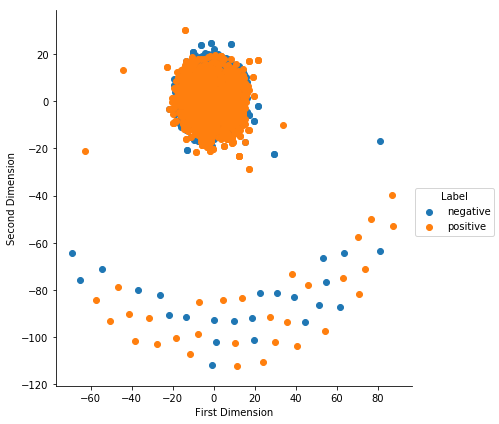

In [52]:
sbn.FacetGrid(df_bigram_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

### Tfidf

In [53]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf = tfidf_vec.fit_transform(df_np['cleaned_text'].values)

In [55]:
tfidf.shape

(3000, 101053)

In [56]:
features = tfidf_vec.get_feature_names()
len(features)

101053

In [57]:
features[100000:100010]

['written',
 'written amazon',
 'written bottl',
 'written clever',
 'written compani',
 'written custom',
 'written direct',
 'written know',
 'written latin',
 'written left']

In [59]:
review_vector_3k=tfidf.toarray()

In [60]:
review_vector_3k.shape

(3000, 101053)

In [61]:
review_vector_3k_tsne = tsne.fit_transform(review_vector_3k)

In [62]:
review_vector_3k_tsne.shape

(3000, 2)

In [64]:
pickle_file = open('pickled_3k_reviews_tsne_tfidf.pkl', 'wb')
pickle.dump(review_vector_3k_tsne, pickle_file)
pickle_file.close()

In [65]:
tfidf_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_tfidf_tsne_3k = pd.DataFrame(tfidf_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [67]:
df_tfidf_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,22.4675,-47.4719,negative
1,22.0417,-52.8478,negative
2,24.0581,-49.3262,negative
3,24.5416,-48.7316,negative
4,78.1818,-19.5757,negative


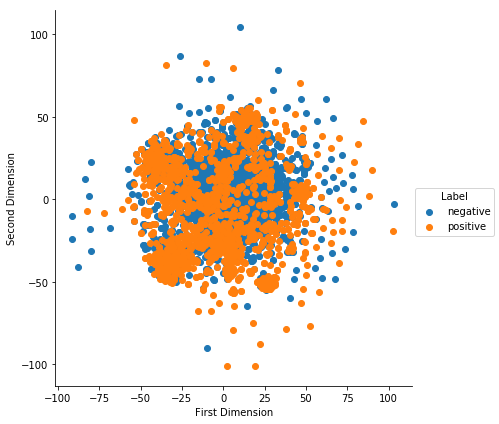

In [68]:
sbn.FacetGrid(df_tfidf_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

In [73]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

In [85]:
#train_corpus = gensim.utils.simple_preprocess(df_np['cleaned_text'][1])

def read_corpus(df_np, tokens_only=False):
        for i, review in enumerate(df_np['cleaned_text']):
            if tokens_only:
                yield gensim.utils.simple_preprocess(review)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(review), [i])

train_corpus = list(read_corpus(df_np))

In [136]:
train_corpus

[TaggedDocument(words=['alway', 'enjoy', 'movi', 'funni', 'entertain', 'didnt', 'hesit', 'pick', 'clamshel', 'edit', 'guess', 'market', 'plan', 'make', 'movi', 'famili', 'someth', 'elimin', 'strong', 'profan', 'element', 'usual', 'edit', 'televis', 'version', 'warn', 'want', 'uncut', 'version', 'avoid', 'clamshel', 'edit'], tags=[0]),
 TaggedDocument(words=['michael', 'keaton', 'bring', 'distinguish', 'characterist', 'ghoul', 'beetlejuic', 'mere', 'act', 'bizarr', 'script', 'often', 'stun', 'cinematographi', 'movi', 'come', 'focu', 'like', 'find', 'one', 'beetlejuic', 'snack', 'popcorn'], tags=[1]),
 TaggedDocument(words=['continu', 'amaz', 'shoddi', 'treatment', 'movi', 'get', 'dvd', 'releas', 'dvd', 'simpli', 'disgrac', 'especi', 'consid', 'great', 'movi', 'give', 'movi', 'wonder', 'exampl', 'tim', 'burton', 'energi', 'style', 'dvd', 'extra', 'worth', 'mention', 'delet', 'scene', 'featurett', 'even', 'lousi', 'commentari', 'track', 'make', 'even', 'wors', 'film', 'cut', 'theatric', '

In [86]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [87]:
model.build_vocab(train_corpus)

In [88]:
model

In [89]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 5.89 s


In [129]:
review_vector_3k = np.zeros((1,50))


for review in df_np['cleaned_text']:
    arr = np.reshape(model.infer_vector(str(review).split()), (1,-1))
    review_vector_3k=np.vstack([review_vector_3k, arr])


    
#model.infer_vector(str(df_np['cleaned_text'][1636]).split())

#df_np['cleaned_text'][1637]
#df_np['cleaned_text']

#np.reshape(model.infer_vector(str(df_np['cleaned_text'][2]).split()), (1,-1)).shape

review_vector_3k = np.delete(review_vector_3k, (0), axis=0)

In [142]:
review_vector_3k.shape

(3000, 50)

In [143]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

review_vector_3k = scaler.fit_transform(review_vector_3k)

In [144]:
tsne = TSNE(n_components=2, random_state=33, perplexity=40)

review_vector_3k_tsne = tsne.fit_transform(review_vector_3k)

In [145]:
review_vector_3k_tsne.shape

(3000, 2)

In [146]:
d2v_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_d2v_tsne_3k = pd.DataFrame(d2v_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [140]:
df_d2v_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,13.4623,-9.81128,negative
1,-1.67255,0.441635,negative
2,-19.1338,4.7497,negative
3,-19.0741,4.69081,negative
4,6.38907,3.53909,negative


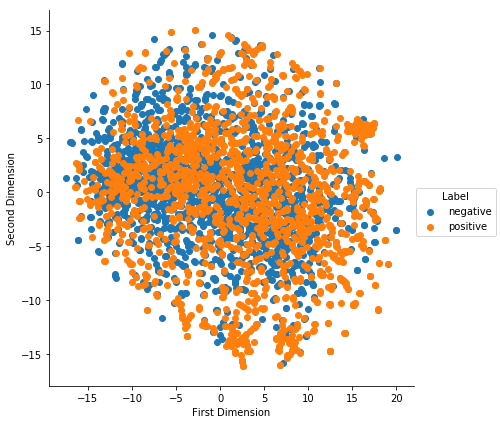

In [147]:
sbn.FacetGrid(df_d2v_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()